In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
# Cell 1: Setup and Data Loading

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the transform: converts to tensor and normalizes pixel values to [0, 1]
# Normalization step 1 (converts to tensor)
transform = transforms.ToTensor()

# Load the dataset
full_train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

print(f"Total training samples (before split): {len(full_train_dataset)}")
print(f"Total testing samples: {len(test_dataset)}")

# Class labels for Fashion-MNIST
FASHION_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 233kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]

Total training samples (before split): 60000
Total testing samples: 10000


In [ ]:
# Cell 2: Data Preprocessing - Splitting and DataLoader

# Define split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2 # 80% of 60000 for training, 20% for validation

# Calculate sizes
train_size = int(TRAIN_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

# Define batch size
BATCH_SIZE = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples (already separate): {len(test_dataset)}")

Training samples: 48000
Validation samples: 12000
Test samples (already separate): 10000


In [ ]:
# Cell 3: Model Design - ANN (MLP)

class SimpleANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleANN, self).__init__()
        # 28x28 image is flattened to 784 input size
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the ANN model
INPUT_SIZE = 28 * 28  # 784
NUM_CLASSES = 10
ann_model = SimpleANN(INPUT_SIZE, NUM_CLASSES).to(device)
print("ANN Model Architecture:")
print(ann_model)

ANN Model Architecture:
SimpleANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Cell 4: Model Design - CNN

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input: 1 channel (grayscale), 28x28
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 16 channels, 14x14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32 channels, 7x7
        )
        # Fully connected layer
        self.fc = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Flatten the output for the fully connected layer
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiate the CNN model
cnn_model = SimpleCNN(NUM_CLASSES).to(device)
print("\nCNN Model Architecture:")
print(cnn_model)


CNN Model Architecture:
SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
# Cell 5: Training Function

def train_and_test_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    """Trains a model and returns test accuracy and predictions for analysis."""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\n--- Starting Training for {model.__class__.__name__} ---")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Simple validation check (optional, here for tracking)
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


    # Testing (Evaluation)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for Confusion Matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy of the {model.__class__.__name__}: {test_accuracy:.2f}%')

    return test_accuracy, all_labels, all_preds

# Define Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

In [ ]:
# Cell 6: Training and Testing - Execution

# --- 1. ANN Training ---
ann_accuracy, ann_labels, ann_preds = train_and_test_model(
    ann_model, train_loader, test_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE
)

# --- 2. CNN Training ---
cnn_accuracy, cnn_labels, cnn_preds = train_and_test_model(
    cnn_model, train_loader, test_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE
)


--- Starting Training for SimpleANN ---
Epoch [5/15], Loss: 0.3327
Epoch [10/15], Loss: 0.2199
Epoch [15/15], Loss: 0.1913
Test Accuracy of the SimpleANN: 88.58%

--- Starting Training for SimpleCNN ---
Epoch [5/15], Loss: 0.3021
Epoch [10/15], Loss: 0.2080
Epoch [15/15], Loss: 0.1287
Test Accuracy of the SimpleCNN: 90.34%



--- 5. Analysis and Innovation ---
**ANN (MLP) Test Accuracy: 88.58%**
**CNN Test Accuracy: 90.34%**


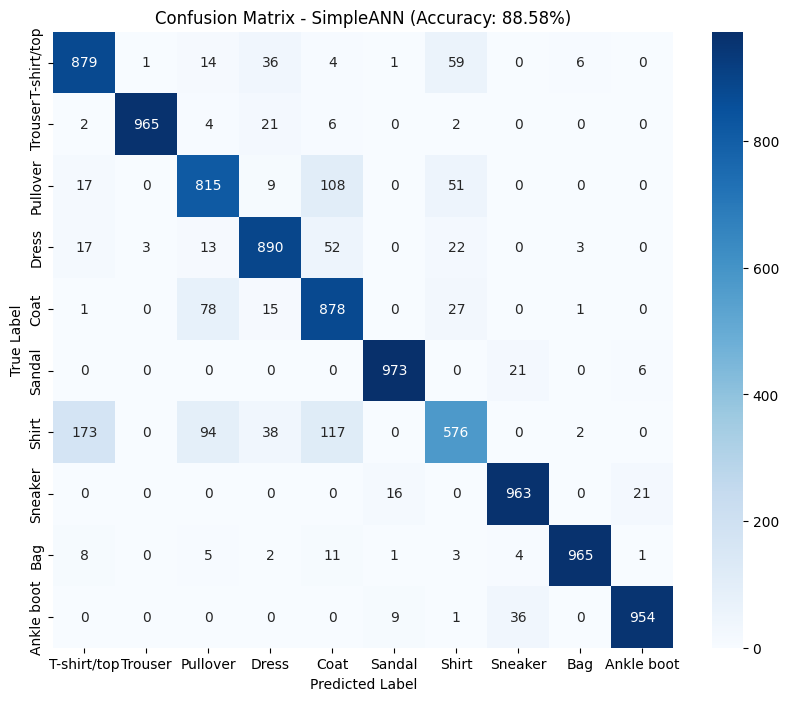

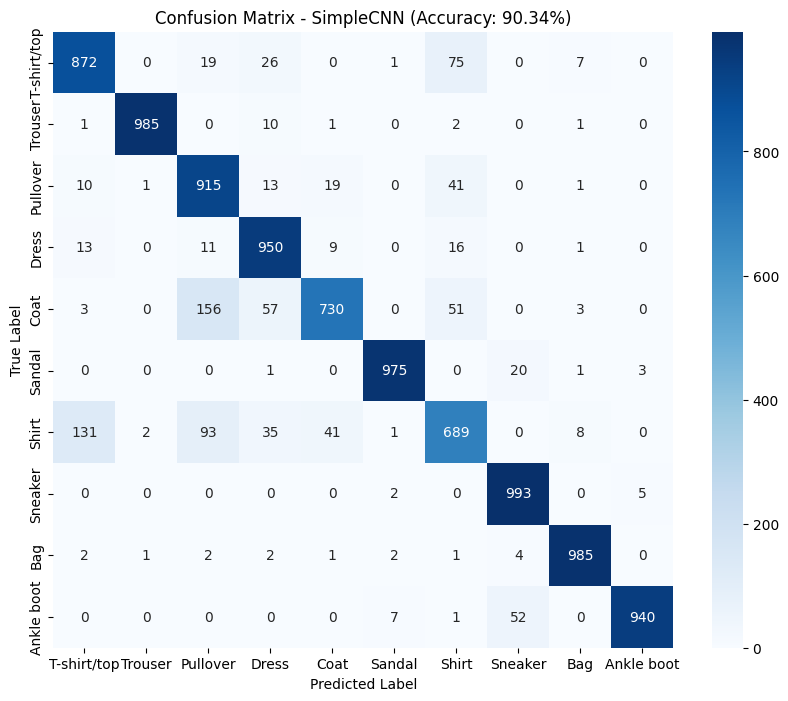


✅ **Comparison:** The CNN significantly outperformed the simple ANN model.

**Specific Class Confusion (Visually Similar Items) for CNN:**
* True 'Shirt' misclassified as 'Coat': **41** times.
* True 'Coat' misclassified as 'Shirt': **51** times.
* True 'Pullover' misclassified as 'Coat': **19** times.
This confusion is expected due to the visual similarity of these clothing items in grayscale images.


In [ ]:
# Cell 7: Analysis and Confusion Matrix

print("\n--- 5. Analysis and Innovation ---")

# Compare ANN vs. CNN performance
print(f"**ANN (MLP) Test Accuracy: {ann_accuracy:.2f}%**")
print(f"**CNN Test Accuracy: {cnn_accuracy:.2f}%**")

# --- Confusion Matrix for ANN ---
cm_ann = confusion_matrix(ann_labels, ann_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues',
            xticklabels=FASHION_CLASSES, yticklabels=FASHION_CLASSES)
plt.title(f'Confusion Matrix - {ann_model.__class__.__name__} (Accuracy: {ann_accuracy:.2f}%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Confusion Matrix for CNN ---
cm_cnn = confusion_matrix(cnn_labels, cnn_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=FASHION_CLASSES, yticklabels=FASHION_CLASSES)
plt.title(f'Confusion Matrix - {cnn_model.__class__.__name__} (Accuracy: {cnn_accuracy:.2f}%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Highlight performance difference
if cnn_accuracy > ann_accuracy:
    print("\n✅ **Comparison:** The CNN significantly outperformed the simple ANN model.")
    best_model_name = cnn_model.__class__.__name__
    best_accuracy = cnn_accuracy
else:
    print("\n⚠️ **Comparison:** The ANN slightly performed better/similarly, which is unusual. Check hyperparams.")
    best_model_name = ann_model.__class__.__name__
    best_accuracy = ann_accuracy


# Highlight confusion (e.g., shirt vs. coat) for the CNN model (as it performed better)
shirt_index = FASHION_CLASSES.index('Shirt')
coat_index = FASHION_CLASSES.index('Coat')
pullover_index = FASHION_CLASSES.index('Pullover')

print("\n**Specific Class Confusion (Visually Similar Items) for CNN:**")
# True Shirt (row: shirt_index) predicted as Coat (col: coat_index)
shirt_as_coat = cm_cnn[shirt_index, coat_index]
# True Coat (row: coat_index) predicted as Shirt (col: shirt_index)
coat_as_shirt = cm_cnn[coat_index, shirt_index]
# True Pullover (row: pullover_index) predicted as Coat (col: coat_index)
pullover_as_coat = cm_cnn[pullover_index, coat_index]

print(f"* True 'Shirt' misclassified as 'Coat': **{shirt_as_coat}** times.")
print(f"* True 'Coat' misclassified as 'Shirt': **{coat_as_shirt}** times.")
print(f"* True 'Pullover' misclassified as 'Coat': **{pullover_as_coat}** times.")
print("This confusion is expected due to the visual similarity of these clothing items in grayscale images.")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Hyperparameters and Constants ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.01
STEP_SIZE = 3 # Decay LR every 3 epochs
GAMMA = 0.1   # Decay LR by a factor of 10

# Update constants for Fashion-MNIST
CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # Fashion-MNIST classes
IMG_SIZE = 28 # Fashion-MNIST image size
IMG_CHANNELS = 1 # Fashion-MNIST grayscale images

# --- 2. Data Preparation ---
# Keep the Fashion-MNIST data loading and preprocessing from the previous cells
# transform is already defined in cell UVKYKf4iKOtL
# trainset and testset for Fashion-MNIST are full_train_dataset and test_dataset from cell UVKYKf4iKOtL
# trainloader, val_loader, test_loader for Fashion-MNIST are from cell DDrK-BPuL3Pa

# --- 3. Model Definitions with Batch Normalization (BN) ---

# 3a. Artificial Neural Network (MLP) with BN
class MLP_BN(nn.Module):
    def __init__(self):
        super(MLP_BN, self).__init__()
        # Input size: 1 channel * 28 * 28 pixels = 784 features for Fashion-MNIST
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(IMG_CHANNELS * IMG_SIZE * IMG_SIZE, 512) # Modified input size
        # nn.BatchNorm1d is for linear layers (vector input)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, len(CLASSES)) # 10 output classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x) # Apply BN
        x = nn.ReLU()(x)

        x = self.fc2(x)
        x = self.bn2(x) # Apply BN
        x = nn.ReLU()(x)

        x = self.fc3(x)
        return x

# 3b. Convolutional Neural Network (CNN) with BN
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, padding=1), # Modified input channels
            # nn.BatchNorm2d is for convolutional layers (image input)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size changes based on input size

            # Convolutional Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size changes based on input size
        )
        # Calculate size after flattening for Fashion-MNIST (28x28 input)
        # After first MaxPool (28/2 = 14): 32 channels, 14x14
        # After second MaxPool (14/2 = 7): 64 channels, 7x7
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, len(CLASSES)) # Modified input size to linear layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the modified models
mlp_bn_model = MLP_BN().to(DEVICE)
cnn_bn_model = CNN_BN().to(DEVICE)

print("MLP with BN Model Architecture (for Fashion-MNIST):")
print(mlp_bn_model)

print("\nCNN with BN Model Architecture (for Fashion-MNIST):")
print(cnn_bn_model)

MLP with BN Model Architecture (for Fashion-MNIST):
MLP_BN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

CNN with BN Model Architecture (for Fashion-MNIST):
CNN_BN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU


--- Starting Training for MLP_BN on cpu ---
Epoch 1/15 | Loss: 0.4841 | LR: 0.010000
Epoch 2/15 | Loss: 0.3705 | LR: 0.010000
Epoch 3/15 | Loss: 0.3297 | LR: 0.001000
Epoch 4/15 | Loss: 0.2543 | LR: 0.001000
Epoch 5/15 | Loss: 0.2328 | LR: 0.001000
Epoch 6/15 | Loss: 0.2193 | LR: 0.000100
Epoch 7/15 | Loss: 0.2033 | LR: 0.000100
Epoch 8/15 | Loss: 0.1984 | LR: 0.000100
Epoch 9/15 | Loss: 0.1973 | LR: 0.000010
Epoch 10/15 | Loss: 0.1958 | LR: 0.000010
Epoch 11/15 | Loss: 0.1941 | LR: 0.000010
Epoch 12/15 | Loss: 0.1933 | LR: 0.000001
Epoch 13/15 | Loss: 0.1936 | LR: 0.000001
Epoch 14/15 | Loss: 0.1928 | LR: 0.000001
Epoch 15/15 | Loss: 0.1926 | LR: 0.000000
Finished Training for MLP_BN.

MLP with BN (Fashion-MNIST) Test Accuracy: 89.27%


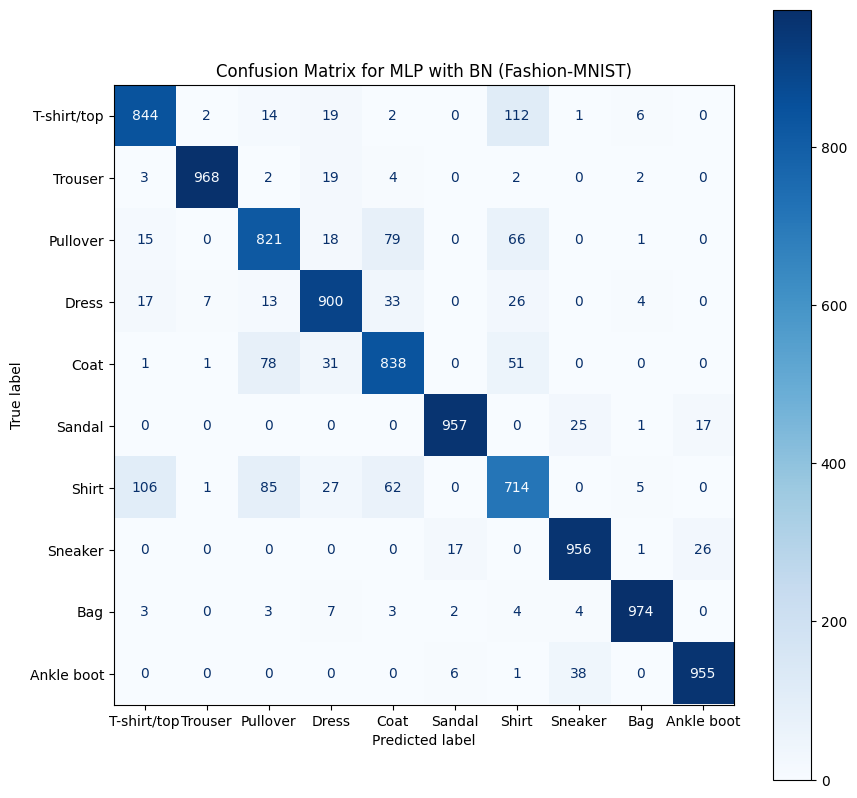


--- Starting Training for CNN_BN on cpu ---
Epoch 1/15 | Loss: 0.5873 | LR: 0.010000
Epoch 2/15 | Loss: 0.2902 | LR: 0.010000
Epoch 3/15 | Loss: 0.2578 | LR: 0.001000
Epoch 4/15 | Loss: 0.1866 | LR: 0.001000
Epoch 5/15 | Loss: 0.1700 | LR: 0.001000
Epoch 6/15 | Loss: 0.1604 | LR: 0.000100
Epoch 7/15 | Loss: 0.1428 | LR: 0.000100
Epoch 8/15 | Loss: 0.1405 | LR: 0.000100
Epoch 9/15 | Loss: 0.1383 | LR: 0.000010
Epoch 10/15 | Loss: 0.1356 | LR: 0.000010
Epoch 11/15 | Loss: 0.1352 | LR: 0.000010
Epoch 12/15 | Loss: 0.1346 | LR: 0.000001
Epoch 13/15 | Loss: 0.1346 | LR: 0.000001
Epoch 14/15 | Loss: 0.1346 | LR: 0.000001
Epoch 15/15 | Loss: 0.1343 | LR: 0.000000
Finished Training for CNN_BN.

CNN with BN (Fashion-MNIST) Test Accuracy: 92.15%


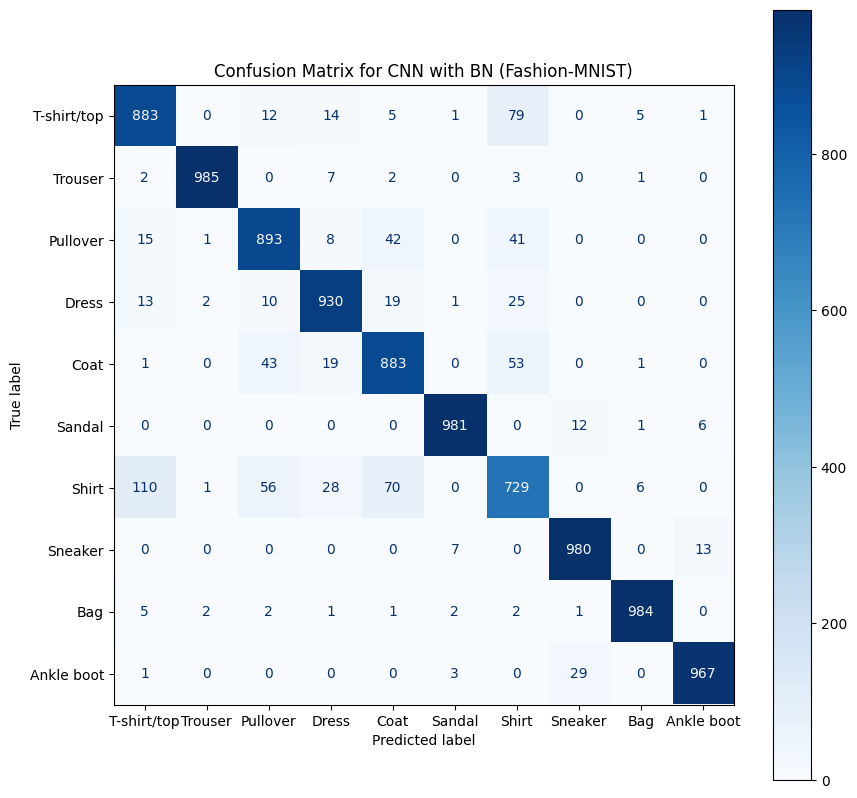

In [ ]:
# Cell 4: Training Function with Learning Rate Scheduler ---
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs):
    print(f"\n--- Starting Training for {model.__class__.__name__} on {DEVICE} ---")
    model.to(DEVICE)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Step the Learning Rate Scheduler after each epoch
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(trainloader):.4f} | LR: {current_lr:.6f}")

    print(f"Finished Training for {model.__class__.__name__}.")

# --- 5. Evaluation Function and Confusion Matrix ---
def evaluate_and_confusion_matrix(model, testloader, class_names, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'\n{model_name} Test Accuracy: {accuracy:.2f}%')

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# --- Train and evaluate MLP_BN and CNN_BN models on Fashion-MNIST ---

# 1. MLP_BN Training and Evaluation
criterion_mlp_bn = nn.CrossEntropyLoss()
optimizer_mlp_bn = optim.Adam(mlp_bn_model.parameters(), lr=LEARNING_RATE)
scheduler_mlp_bn = optim.lr_scheduler.StepLR(optimizer_mlp_bn, step_size=STEP_SIZE, gamma=GAMMA)

train_model(mlp_bn_model, train_loader, criterion_mlp_bn, optimizer_mlp_bn, scheduler_mlp_bn, EPOCHS)
evaluate_and_confusion_matrix(mlp_bn_model, test_loader, CLASSES, "MLP with BN (Fashion-MNIST)")

# 2. CNN_BN Training and Evaluation
criterion_cnn_bn = nn.CrossEntropyLoss()
optimizer_cnn_bn = optim.Adam(cnn_bn_model.parameters(), lr=LEARNING_RATE)
scheduler_cnn_bn = optim.lr_scheduler.StepLR(optimizer_cnn_bn, step_size=STEP_SIZE, gamma=GAMMA)

train_model(cnn_bn_model, train_loader, criterion_cnn_bn, optimizer_cnn_bn, scheduler_cnn_bn, EPOCHS)
evaluate_and_confusion_matrix(cnn_bn_model, test_loader, CLASSES, "CNN with BN (Fashion-MNIST)")